In [12]:
%matplotlib inline

from numpy import sqrt, log 
from clawpack import riemann
from clawpack import pyclaw

def xfr(t): return sqrt(1+t)/2

def qtrue(x,t):
    """
    The true solution, for comparison.  
    """
    import numpy as np
    xf = xfr(t) 

    if isinstance(x,(np.ndarray,list)):
        dim = x.shape[0] 
        q   = np.empty(dim)
     
        for i in range(dim):
            if x[i]>=0.0 and x[i]<=xf:
                q[i] = (x[i]) /(t+1)
            else:
                q[i] = 0
    if isinstance(x,(float,int)):
        if x>=0 and x<=xf:
            q=x/(t+1)
        else:
            q=0
    return q

def qinit(x):
    """
    The true solution, for comparison.  
    """
    from numpy import mod, exp, where, logical_and
    q = qtrue(x,0)
    return q

def burgers(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    1d burgers riemann solver 
    """
    import numpy as np
    num_eqn = 1
    num_waves = 1

    # Convenience
    num_rp = q_l.shape[1]

    # Return values
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.empty( (num_waves, num_rp) )
    amdq = np.empty( (num_eqn, num_rp) )
    apdq = np.empty( (num_eqn, num_rp) )

    # Local values
    delta = np.empty(np.shape(q_l))

    delta = q_r - q_l
    
    
    # Compute the wave
    # 1-Wave
    wave[0,0,:] = delta 
    s[0,:] = 0.5 * (q_r[0,:] + q_l[0,:])
    
    # Compute the left going and right going fluctuations
    s_index = np.zeros((2,num_rp))
    s_index[0,:] = s[0,:]
    amdq[0,:] = np.min(s_index,axis=0) * wave[0,0,:]
    apdq[0,:] = np.max(s_index,axis=0) * wave[0,0,:]
        
    # Compute entropy fix
    if problem_data['efix']:
        transonic = (q_l[0,:] < 0.0) * (q_r[0,:] > 0.0)
        amdq[0,transonic] = -0.5 * q_l[0,transonic]**2
        apdq[0,transonic] = 0.5 * q_r[0,transonic]**2

    return wave, s, amdq, apdq


def setup(outdir='./_output',  output_style=1):
    
    solver = pyclaw.ClawSolver1D()
    
    #solver.rp = riemann.burgers_1D_py.burgers_1D
    #solver = pyclaw.SharpClawSolver1D()
    solver.rp = burgers
    #solver.weno_order = 5
    #solver.lim_type = 2
    #solver.time_integrator = 'SSP33'
    #solver.cfl_max = 0.5

    solver.num_waves = 1
    solver.num_eqn = 1
    solver.kernel_language = 'Python'
    solver.limiters = pyclaw.limiters.tvd.superbee
    solver.bc_lower[0] = pyclaw.BC.extrap
    solver.bc_upper[0] = pyclaw.BC.extrap
    solver.order = 2 #1: Godunov, 2: Lax-Wendroff-LeVeque
    
    x = pyclaw.Dimension(-0.10, 1.5, 320, name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 1
    
    state = pyclaw.State(domain, num_eqn)
    
     
    state.problem_data['efix'] = True
    
    xc = domain.grid.x.centers
    
    state.q[0, :] = qtrue(xc, 0)
     
    claw = pyclaw.Controller()
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver = solver
    claw.outdir = outdir
    claw.output_style = output_style
    claw.tfinal = 2.0
    claw.num_output_times = 20
    claw.keep_copy = True
    #claw.setplot = setplot

    return claw


def setplot(plotdata):
    """ 
    Plot solution using VisClaw.
    """ 
    plotdata.clearfigures()  # clear any old figures,axes,items data

    plotfigure = plotdata.new_plotfigure(name='q', figno=1)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.ylimits = [-.2,1.0]
    plotaxes.title = 'q'

    # Set up for item on these axes:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 0
    plotitem.plotstyle = '-o'
    plotitem.color = 'b'
    plotitem.kwargs = {'linewidth':2,'markersize':5}
    
    return plotdata


2024-04-01 19:16:21,308 INFO CLAW: Solution 0 computed for time t=0.000000
2024-04-01 19:16:21,316 INFO CLAW: Solution 1 computed for time t=0.100000
2024-04-01 19:16:21,321 INFO CLAW: Solution 2 computed for time t=0.200000
2024-04-01 19:16:21,326 INFO CLAW: Solution 3 computed for time t=0.300000
2024-04-01 19:16:21,331 INFO CLAW: Solution 4 computed for time t=0.400000
2024-04-01 19:16:21,336 INFO CLAW: Solution 5 computed for time t=0.500000
2024-04-01 19:16:21,341 INFO CLAW: Solution 6 computed for time t=0.600000
2024-04-01 19:16:21,348 INFO CLAW: Solution 7 computed for time t=0.700000
2024-04-01 19:16:21,355 INFO CLAW: Solution 8 computed for time t=0.800000
2024-04-01 19:16:21,361 INFO CLAW: Solution 9 computed for time t=0.900000
2024-04-01 19:16:21,366 INFO CLAW: Solution 10 computed for time t=1.000000
2024-04-01 19:16:21,371 INFO CLAW: Solution 11 computed for time t=1.100000
2024-04-01 19:16:21,379 INFO CLAW: Solution 12 computed for time t=1.200000
2024-04-01 19:16:21,38

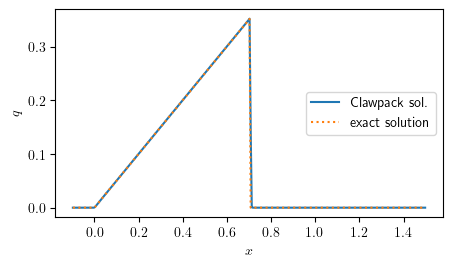

In [13]:
claw = setup()
claw.run()
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
index = 10
frame = claw.frames[index]
dt = claw.tfinal/claw.num_output_times
t = dt*index
x = frame.state.grid.c_centers
x = x[0]
true = qtrue(x,t)
fig, ax = plt.subplots(figsize=(5, 2.7))
w = frame.q[0,:]

ax.plot(x, w, label='Clawpack sol.')
ax.plot(x, true, ':',label='exact solution')
ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$q$')
plt.savefig("InitialValueBurgerClaw.pdf")

In [14]:
nsimul=np.size(claw.frames)
figs = []
for i in range(nsimul):
    fig, ax = plt.subplots(figsize=(5, 3))
     
    frame = claw.frames[i]
    w     = frame.q[0,:]
    x     = frame.state.grid.c_centers
    x     = x[0]
    dt    = claw.tfinal/claw.num_output_times
    t     = dt*i
    true  = qtrue(x,t)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$q$')
    plt.plot(x, w)
    plt.plot(x, true, '--',color = 'r')
    figs.append(fig)
    plt.close(fig)
    
from clawpack.visclaw import animation_tools
animation_tools.interact_animate_figs(figs)    

interactive(children=(IntSlider(value=0, description='frameno', max=20), Output()), _dom_classes=('widget-inte…

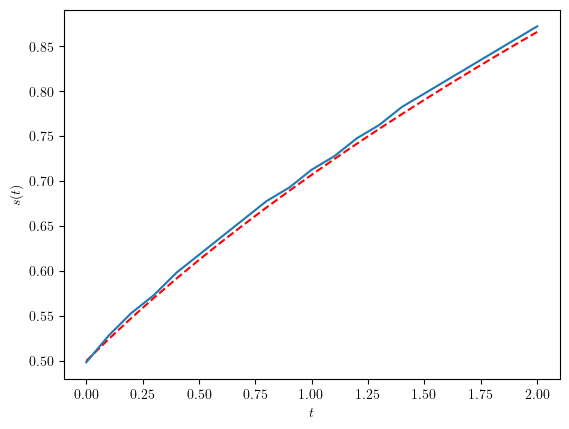

In [15]:
nsimul=np.size(claw.frames)
positionFront = []
for i in range(nsimul):
    frame = claw.frames[i]
    w = frame.q[0,:]
    xc=frame.state.grid.c_centers[0]
    nx=xc.size
    dx=(xc[-1]-xc[0])/nx
    pos= dx*w[w>1.e-5].size
    positionFront.append(pos)
t = np.linspace(0, claw.tfinal, nsimul)
xfront = xfr(t)

fig, ax = plt.subplots()
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$s(t)$')

ax.plot(t, xfront, '--',color = 'r')
ax.plot(t, positionFront)
plt.savefig("frontBurgerClaw.pdf") 

In [22]:
def burgers_animation():
    import matplotlib.animation
    import numpy
    # compute the solution with the method defined above:
    claw = setup()
    claw.keep_copy = True
    claw.run()
    x = claw.frames[0].grid.dimensions[0].centers
    x_true = numpy.linspace(0., 1.5 , 1000)
    
    fig = plt.figure()
    axes = plt.subplot(1, 1, 1)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((0, 0.5))
    axes.set_title(" ")
    text = axes.text(1.5, 0.9, '')
    
    def init():
        axes.set_xlim((x[0], x[-1]))
        axes.set_ylim((-0,0.5))

        computed_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'r')
        exact_line, = axes.plot(x_true[0], qinit(x_true[0]), 'k--')
        return  (computed_line, exact_line)
    
    computed_line, exact_line = init()
    #computed_line  = init()
    
    def fplot(n):
        tt = claw.frames[n].t 
        computed_line.set_data([x,], [claw.frames[n].q[0, :]])
        exact_line.set_data([x_true], [qtrue(x_true,tt)])
        
        text.set_text(f't = {tt:.2f} s' )
        return (computed_line, exact_line)

    frames_to_plot = range(0, len(claw.frames))
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=None, repeat=False)

In [23]:
from IPython.display import HTML 
anim = burgers_animation()
HTML(anim.to_jshtml())

2024-04-01 19:23:11,094 INFO CLAW: Solution 0 computed for time t=0.000000
2024-04-01 19:23:11,099 INFO CLAW: Solution 1 computed for time t=0.100000
2024-04-01 19:23:11,105 INFO CLAW: Solution 2 computed for time t=0.200000
2024-04-01 19:23:11,110 INFO CLAW: Solution 3 computed for time t=0.300000
2024-04-01 19:23:11,115 INFO CLAW: Solution 4 computed for time t=0.400000
2024-04-01 19:23:11,122 INFO CLAW: Solution 5 computed for time t=0.500000
2024-04-01 19:23:11,127 INFO CLAW: Solution 6 computed for time t=0.600000
2024-04-01 19:23:11,131 INFO CLAW: Solution 7 computed for time t=0.700000
2024-04-01 19:23:11,137 INFO CLAW: Solution 8 computed for time t=0.800000
2024-04-01 19:23:11,143 INFO CLAW: Solution 9 computed for time t=0.900000
2024-04-01 19:23:11,150 INFO CLAW: Solution 10 computed for time t=1.000000
2024-04-01 19:23:11,157 INFO CLAW: Solution 11 computed for time t=1.100000
2024-04-01 19:23:11,161 INFO CLAW: Solution 12 computed for time t=1.200000
2024-04-01 19:23:11,16